# Field-weighted Factorization Machines

This is the implementation of the part of [FwFM](https://arxiv.org/abs/1806.03514) to see feature interactions.

In [1]:
import sys
sys.path.append('..')

In [2]:
import datetime
import os
import pickle
from pathlib import Path

import itertools
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tqdm import tqdm
from pandas import DataFrame

from src.config import TrainConfig
from src.data.data_generator import DataGenerator
from src.data import preprocessors
from src.losses import pairwise_losses
from src.utils.seed import set_seed
from src.utils.plot import plot_history
from src.metrics import metrics
from src.models.base_model import BaseModel
from src.layers.bias import AddBias0

import matplotlib.pyplot as plt
import seaborn as sns

project_dir = '../..'
dataset_size = 'small'

In [3]:
class WeightedInteraction(tf.keras.layers.Layer):
    def __init__(self, num_fields, **kwargs):
        self.num_fields = num_fields
        super(WeightedInteraction, self).__init__(**kwargs)

    def build(self, input_shape):
        w_init = tf.constant_initializer(value=0)
        self.field_weights = tf.Variable(
            initial_value=w_init(shape=(self.num_fields, self.num_fields), dtype=tf.float32),
            name='field_weights',
        )
        self.dot = layers.Dot(axes=1, normalize=True)
        self.dense1 = layers.Dense(8, activation='relu')
        self.dense2 = layers.Dense(1, activation='relu')
        super(WeightedInteraction, self).build(input_shape)

    def call(self, inputs):
        dim = inputs.shape[1] // self.num_fields
        interactions = []
        for i, j in itertools.combinations(range(self.num_fields), 2):
            feature1, feature2 = inputs[:, i*dim:(i+1)*dim], inputs[:, j*dim:(j+1)*dim]
            interaction = self.dot([feature1, feature2])
            interaction = tf.math.scalar_mul(self.field_weights[i, j], interaction)
            interactions.append(interaction)
        return layers.concatenate(interactions)
    
    def compute_output_shape(self, input_shape):
        return None, self.num_fields

    def get_config(self):
        config = super(WeightedInteraction, self).get_config().copy()
        config.update({
            'num_fields': self.num_fields,
        })
        return config
    
class FwFM(BaseModel):
    @property
    def name(self) -> str:
        return 'fwfm'

    def build(self):
        categorical_input_size = {
            'country': self.total_countries,
        }

        text_inputs = [
            self.new_query_input(),
            self.new_title_input(),
            self.new_ingredients_input(),
            self.new_description_input(),
        ]
        categorical_inputs = [
            self.new_country_input(),
        ]
        
        inputs = text_inputs + categorical_inputs

        embedding = layers.Embedding(self.total_words, self.embedding_dim, name='text_embedding')
        text_features = [embedding(text_input) for text_input in text_inputs]
        text_features = [layers.GlobalMaxPooling1D()(feature) for feature in text_features]
        
        categorical_features = []
        for name, categorical_input in zip(categorical_input_size, categorical_inputs):
            embedding = layers.Embedding(categorical_input_size[name], self.embedding_dim)
            feature = embedding(categorical_input)
            feature = tf.reshape(feature, shape=(-1, self.embedding_dim,))
            categorical_features.append(feature)
            
        features = text_features + categorical_features

        num_fields = len(features)
        features = tf.concat(features, axis=1)
        weighted_interaction = WeightedInteraction(num_fields)
        interactions = weighted_interaction(features)
        
        visualizer = tf.keras.Model(inputs=inputs, outputs=interactions)
        
        x = tf.keras.backend.sum(interactions, axis=1, keepdims=True)
        output = layers.Activation('sigmoid', name='label')(x)
        return tf.keras.Model(inputs=inputs, outputs=output, name=self.name), visualizer

In [4]:
config = TrainConfig(
    dataset=f'listwise.{dataset_size}',
    data_processor=preprocessors.ConcatDataProcessor(dataset_size=dataset_size),
    data_processor_filename=f'concat_data_processor.{dataset_size}',
    model=FwFM,
    epochs=10,
)

In [5]:
data_processor = config.data_processor
train_df = data_processor.listwise_to_pairs(f'{config.dataset}.train.pkl')
val_df = data_processor.listwise_to_pairs(f'{config.dataset}.val.pkl')
data_processor.fit(train_df)

train_generator = DataGenerator(train_df, data_processor)
val_generator = DataGenerator(val_df, data_processor)

100%|██████████| 1147/1147 [00:00<00:00, 184049.38it/s]


In [6]:
model, visualizer = config.model(data_processor).build()
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss={'label': pairwise_losses.cross_entropy_loss},
    metrics=['accuracy']
)
model.summary()

Model: "fwfm"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
query (InputLayer)              [(None, 6)]          0                                            
__________________________________________________________________________________________________
title (InputLayer)              [(None, 20)]         0                                            
__________________________________________________________________________________________________
ingredients (InputLayer)        [(None, 300)]        0                                            
__________________________________________________________________________________________________
description (InputLayer)        [(None, 100)]        0                                            
_______________________________________________________________________________________________

In [7]:
history = model.fit(
    train_generator,
    epochs=config.epochs,
    validation_data=val_generator,
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 328 steps, validate for 82 steps
Epoch 1/10
328/328 [==============================] - 26s 80ms/step - loss: 0.6909 - accuracy: 0.5059 - val_loss: 0.6880 - val_accuracy: 0.5125
Epoch 2/10
328/328 [==============================] - 24s 74ms/step - loss: 0.6801 - accuracy: 0.5247 - val_loss: 0.6815 - val_accuracy: 0.5267
Epoch 3/10
328/328 [==============================] - 25s 76ms/step - loss: 0.6568 - accuracy: 0.5653 - val_loss: 0.6748 - val_accuracy: 0.5357
Epoch 4/10
328/328 [==============================] - 25s 77ms/step - loss: 0.6247 - accuracy: 0.6221 - val_loss: 0.6701 - val_accuracy: 0.5419
Epoch 5/10
328/328 [==============================] - 25s 78ms/step - loss: 0.5922 - accuracy: 0.6816 - val_loss: 0.6661 - val_accuracy: 0.5493
Epoch 6/10
328/328 [==============================] - 25s 76ms/step - loss: 0.5624 - accuracy: 0.7293 - val_loss: 0.6632 - val_accuracy: 0.5609
Epoch 7/10
328/328 [=======================

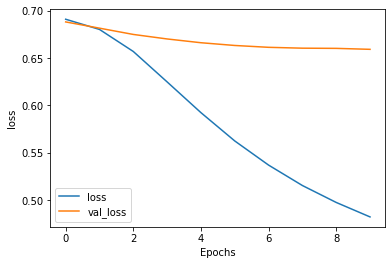

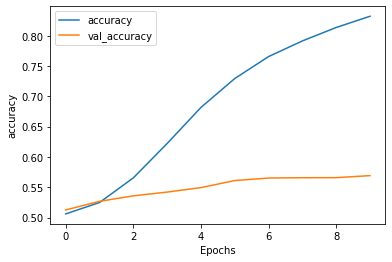

In [8]:
plot_history(history, 'loss')
plot_history(history, 'accuracy')

In [9]:
val_df['pred'] = model.predict(val_generator)
val_df.head()

,query,doc_id,label,pred
0,hot dogs and rice,337213,1,0.036131
1,hot dogs and rice,180615,0,0.013009
2,hot dogs and rice,337213,1,0.036131
3,hot dogs and rice,355693,0,0.033562
4,hot dogs and rice,337213,1,0.036131


(0.5691, 0.6519, 0.2965)

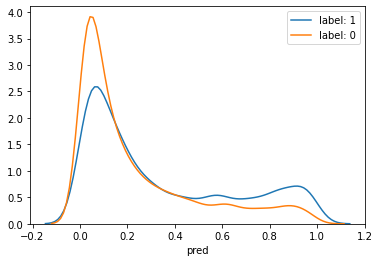

In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

temp = val_df[val_df['label'] == 1]
sns.distplot(temp['pred'], hist=False, label='label: 1')
temp = val_df[val_df['label'] == 0]
sns.distplot(temp['pred'], hist=False, label='label: 0')

y_true = val_df['label']
y_pred = val_df['pred']
round(accuracy_score(y_true, y_pred > 0.5), 4), round(precision_score(y_true, y_pred > 0.5), 4), round(recall_score(y_true, y_pred > 0.5), 4)

In [11]:
from src.data.recipes import load_recipes

recipes = load_recipes(dataset_size)

In [12]:
from IPython.core.display import HTML

def explain(idx, query=None, attrs=None):
    sample = val_df.iloc[idx].copy()
    recipe = recipes[sample['doc_id']].copy()
    if query:
        sample['query'] = query
    if attrs:
        sample['doc_id'] = -1
        recipe['recipe_id'] = -1
        recipe['title'] = attrs['title']
        recipe['ingredients'] = attrs['ingredients']
        recipe['story_or_description'] = attrs['description']
        recipe['country'] = attrs['country']
        data_processor.recipes[-1] = recipe
    samples_df = sample.to_frame().T
    display(samples_df)
    display(HTML(f"<b>query</b>: {sample['query']}"))
    display(HTML(f"<b>title</b>: {recipe['title']}"))
    display(HTML(f"<b>ingredients</b>: {','.join(recipe['ingredients'])}"))
    display(HTML(f"<b>description</b>: {recipe['story_or_description']}"))
    display(HTML(f"<b>country</b>: {recipe['country']}"))
    data = data_processor.process_batch(samples_df)
    dataset = tf.data.Dataset.from_tensor_slices((data))
    generator = dataset.cache().batch(1)
#     generator = DataGenerator(samples_df, data_processor)
    pred = model.predict(generator)[0][0]
    display(HTML(f"<b>pred</b>: {pred:.2f}"))
    output = visualizer.predict(generator)[0]
    w = np.zeros(shape=(5,5))
    for i in range(5):
        w[i][i] = None
    for i, (j, k) in zip(range(10), itertools.combinations(range(5), 2)):
        w[j][k] = output[i]
        w[k][j] = w[j][k]
    label = ['query', 'title', 'ingredients', 'description', 'country']
    sns.heatmap(w, xticklabels=label, yticklabels=label, annot=True)
    plt.show()

,query,doc_id,label,pred
20486,breakfast,220197,1,0.765131


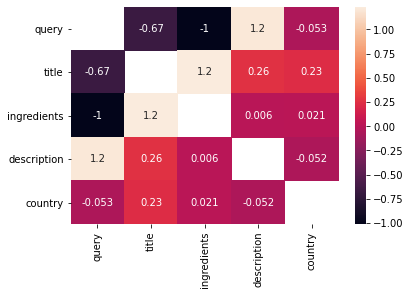

,query,doc_id,label,pred
20487,breakfast,157693,0,0.0713155


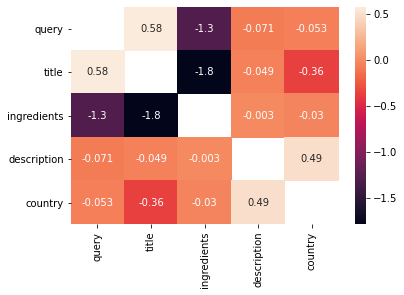

In [13]:
explain(20486) # breakfast positive
explain(20487) # breakfast negative

In [14]:
output = visualizer.predict(val_generator)
importance = output.T

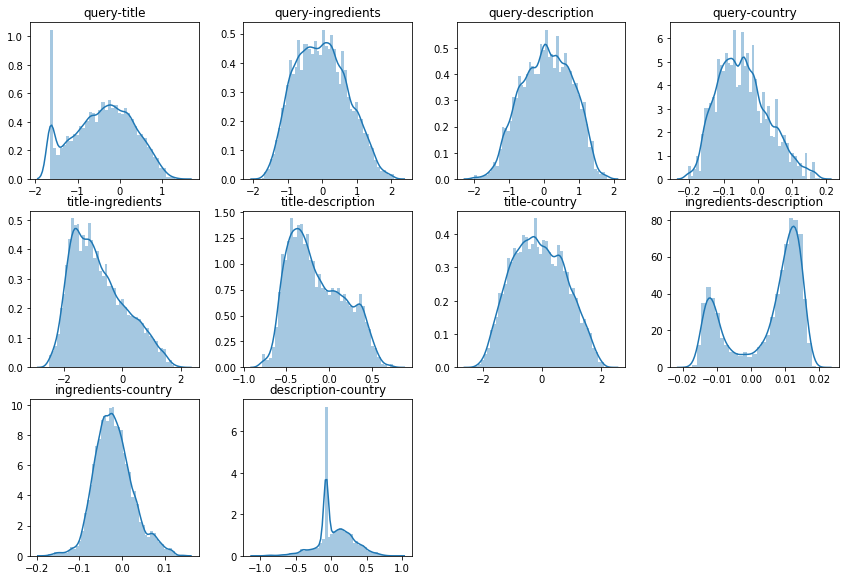

In [16]:
fig, axes = plt.subplots(3, 4, figsize=(12,8))
fig.tight_layout()
titles = [
    'query-title', 'query-ingredients', 'query-description', 'query-country',
    'title-ingredients', 'title-description', 'title-country',
    'ingredients-description', 'ingredients-country',
    'description-country'
]
for i in range(3):
    for j in range(4):
        idx = i * 4 + j
        if idx < len(importance):
            sns.distplot(importance[idx], ax=axes[i][j])
            axes[i][j].set_title(titles[idx])
        else:
            axes[i][j].set_axis_off()